In [1]:
import Pkg; Pkg.activate(".."); Pkg.instantiate();

  Activating project at `c:\Users\matti\Documents\TUe\Thesis\ThesisParallelMP`


In [2]:
using Distributed

In [3]:
addprocs(8);

In [4]:
@everywhere using RxInfer, Random, StatsPlots, LinearAlgebra, ProgressMeter, PGFPlotsX, Revise

In [5]:
@everywhere includet("../distributed.jl")

In [6]:
pgfplotsx()

Plots.PGFPlotsXBackend()

In [7]:
@everywhere begin
    n = 200  # Number of coin flips
    p = 0.75 # Bias of a coin

    distribution = Bernoulli(p)
    dataset      = float.(rand(Bernoulli(p), n))
    prior = Beta(2.0, 6.0)
end

In [8]:
@everywhere begin
    @model function coin_model(n, prior, prod_strategy, pipeline, meta, prod_constraint)

        y = datavar(Float64, n)
        θ = randomvar() where { prod_strategy = prod_strategy, prod_constraint = prod_constraint }

        θ ~ prior

        for i in 1:n
            y[i] ~ Bernoulli(θ) where { pipeline = pipeline, meta = meta  }
        end

    end
end

In [9]:
@everywhere begin
    struct MyCustomRule
        size::Int
    end

    function factorial(n)
        if n == 0 || n == 1
            return 1
        else
            return factorial(n - 1) + factorial(n - 2)
        end
    end

    @rule Bernoulli(:p, Marginalisation) (q_out::PointMass, meta::MyCustomRule) = begin
        @logscale -log(2)
        r = mean(q_out)
        s = factorial(meta.size) / 10^8
        return Beta(one(r) + r, 2one(r) - r + s)
    end
end

In [10]:
struct MyCustomProd
    size::Int
end

function RxInfer.BayesBase.prod(custom::MyCustomProd, left, right)
    r = mean(left)
	s = factorial(custom.size) / 10^8
    return prod(GenericProd(), Beta(one(r) + r, 2one(r) - r + s), right)
end

function RxInfer.BayesBase.prod(custom::MyCustomProd, left::Missing, right)
    return right
end

In [11]:
timing = Ref(0.0)
current_iter = Ref(0.0)

result_full = infer(
    model = coin_model(length(dataset), prior, nothing, nothing, MyCustomRule(30), nothing),
    data  = (y = dataset, ),
    iterations = 1,
    callbacks = (
        before_iteration = (model, iteration) -> begin
            current_iter[] = time_ns()
            return false
        end,
        after_iteration = (model, iteration) -> begin
            current_iter[] = time_ns() - current_iter[]
            timing[] = current_iter[]
            return false
        end
    ),
)

println("Timing: ", timing[] / 1e9)

Timing: 1.1942984


In [12]:
result_full.posteriors[:θ]

1-element Vector{Beta{Float64}}:
 Beta{Float64}(α=149.0, β=61.69253799999974)

In [13]:
channel = RemoteChannel(1)

RemoteChannel{Channel{Any}}(1, 1, 210)

In [14]:
res_prod = Vector{Any}(undef, 1)
timing = Ref(0.0)
current_iter_1 = Ref(0.0)
current_iter_2 = Ref(0.0)

@spawnat 2 infer(
    model = coin_model(Int(length(dataset) / 2), prior, nothing, nothing, MyCustomRule(30), nothing),
    data  = (y = dataset[1:Int(length(dataset) / 2)], ),
    callbacks = (
        on_marginal_update = (model, name, update) -> begin
            put!(channel, RxInfer.ReactiveMP.getdata(update))
        end,
        before_iteration = (model, iteration) -> begin
            current_iter_2[] = time_ns()
            return false
        end,
        after_iteration = (model, iteration) -> begin
            if  current_iter_1[] == 0 || current_iter_2[] == 0
                current_iter_2[] = time_ns() - max(current_iter_1[], current_iter_2[])
            else
                current_iter_2[] = time_ns() - min(current_iter_1[], current_iter_2[])
            end
            timing[] = current_iter_2[]
            return false
        end
    ),
    iterations = 1
)

results_split = infer(
    model = coin_model(Int(length(dataset) / 2), prior, nothing, nothing, MyCustomRule(30), nothing),
    data  = (y = dataset[Int(length(dataset) / 2)+1:end], ),
    callbacks = (
        on_marginal_update = (model, name, update) -> begin
            res_prod[1] = prod(GenericProd(), take!(channel), RxInfer.ReactiveMP.getdata(update))
        end,
        before_iteration = (model, iteration) -> begin
            current_iter_1[] = time_ns()
            return false
        end,
        after_iteration = (model, iteration) -> begin
            if current_iter_1[] == 0 || current_iter_2[] == 0
                current_iter_1[] = time_ns() - max(current_iter_1[], current_iter_2[])
            else
                current_iter_1[] = time_ns() - min(current_iter_1[], current_iter_2[])
            end
            timing[] = current_iter_1[]
            return false
        end
    ),
    iterations = 1
)

println("Time: ", timing[] / 1e9)
println("Result: ", res_prod[1])

Time: 6.3381778
Result: Beta{Float64}(α=150.0, β=66.6925380000001)


In [15]:
function run_sequential_benchmark(size, dataset)
    timing = Ref(0.0)
    current_iter = Ref(0.0)

    result_full = infer(
        model = coin_model(length(dataset), prior, nothing, nothing, MyCustomRule(size), nothing),
        data  = (y = dataset, ),
        iterations = 1,
        callbacks = (
            before_iteration = (model, iteration) -> begin
                current_iter[] = time_ns()
                return false
            end,
            after_iteration = (model, iteration) -> begin
                current_iter[] = time_ns() - current_iter[]
                timing[] = current_iter[]
                return false
            end
        ),
    )

    return timing[]
end

run_sequential_benchmark (generic function with 1 method)

In [16]:
function run_split_benchmark(size, dataset)
    channel1 = RemoteChannel(1)
    channel2 = RemoteChannel(1)
    channel3 = RemoteChannel(1)
    channel4 = RemoteChannel(1)
    channel5 = RemoteChannel(1)
    channel6 = RemoteChannel(1)
    channel7 = RemoteChannel(1)
    res_prod = Vector{Any}(undef, 1)
    timing = Ref(0.0)
    current_iter = Ref(0.0)

    @spawnat 2 infer(
        model = coin_model(Int(length(dataset) / 8), prior, nothing, nothing, MyCustomRule(size), nothing),
        data  = (y = dataset[1:Int(length(dataset) / 8)], ),
        callbacks = (
            on_marginal_update = (model, name, update) -> begin
                put!(channel1, RxInfer.ReactiveMP.getdata(update))
            end,
            before_iteration = (model, iteration) -> begin
                if current_iter[] == 0
                    current_iter[] = time_ns()
                end
                return false
            end,
        ),
        iterations = 1
    )

    @spawnat 3 infer(
        model = coin_model(Int(length(dataset) / 8), prior, nothing, nothing, MyCustomRule(size), nothing),
        data  = (y = dataset[Int(length(dataset) / 8) + 1:(Int(length(dataset) / 8)) * 2], ),
        callbacks = (
            on_marginal_update = (model, name, update) -> begin
                put!(channel2, RxInfer.ReactiveMP.getdata(update))
            end,
            before_iteration = (model, iteration) -> begin
                if current_iter[] == 0
                    current_iter[] = time_ns()
                end
                return false
            end,
        ),
        iterations = 1
    )

    @spawnat 4 infer(
        model = coin_model(Int(length(dataset) / 8), prior, nothing, nothing, MyCustomRule(size), nothing),
        data  = (y = dataset[(Int(length(dataset) / 8)) * 2 + 1:(Int(length(dataset) / 8)) * 3], ),
        callbacks = (
            on_marginal_update = (model, name, update) -> begin
                put!(channel3, RxInfer.ReactiveMP.getdata(update))
            end,
            before_iteration = (model, iteration) -> begin
                if current_iter[] == 0
                    current_iter[] = time_ns()
                end
                return false
            end,
        ),
        iterations = 1
    )

    @spawnat 5 infer(
        model = coin_model(Int(length(dataset) / 8), prior, nothing, nothing, MyCustomRule(size), nothing),
        data  = (y = dataset[(Int(length(dataset) / 8)) * 3 + 1:(Int(length(dataset) / 8)) * 4], ),
        callbacks = (
            on_marginal_update = (model, name, update) -> begin
                put!(channel4, RxInfer.ReactiveMP.getdata(update))
            end,
            before_iteration = (model, iteration) -> begin
                if current_iter[] == 0
                    current_iter[] = time_ns()
                end
                return false
            end,
        ),
        iterations = 1
    )

    @spawnat 6 infer(
        model = coin_model(Int(length(dataset) / 8), prior, nothing, nothing, MyCustomRule(size), nothing),
        data  = (y = dataset[(Int(length(dataset) / 8)) * 4 + 1:(Int(length(dataset) / 8)) * 5], ),
        callbacks = (
            on_marginal_update = (model, name, update) -> begin
                put!(channel5, RxInfer.ReactiveMP.getdata(update))
            end,
            before_iteration = (model, iteration) -> begin
                if current_iter[] == 0
                    current_iter[] = time_ns()
                end
                return false
            end,
        ),
        iterations = 1
    )

    @spawnat 7 infer(
        model = coin_model(Int(length(dataset) / 8), prior, nothing, nothing, MyCustomRule(size), nothing),
        data  = (y = dataset[(Int(length(dataset) / 8)) * 5 + 1:(Int(length(dataset) / 8)) * 6], ),
        callbacks = (
            on_marginal_update = (model, name, update) -> begin
                put!(channel6, RxInfer.ReactiveMP.getdata(update))
            end,
            before_iteration = (model, iteration) -> begin
                if current_iter[] == 0
                    current_iter[] = time_ns()
                end
                return false
            end,
        ),
        iterations = 1
    )

    @spawnat 8 infer(
        model = coin_model(Int(length(dataset) / 8), prior, nothing, nothing, MyCustomRule(size), nothing),
        data  = (y = dataset[(Int(length(dataset) / 8)) * 6 + 1:(Int(length(dataset) / 8)) * 7], ),
        callbacks = (
            on_marginal_update = (model, name, update) -> begin
                put!(channel7, RxInfer.ReactiveMP.getdata(update))
            end,
            before_iteration = (model, iteration) -> begin
                if current_iter[] == 0
                    current_iter[] = time_ns()
                end
                return false
            end,
        ),
        iterations = 1
    )

    infer(
        model = coin_model(Int(length(dataset) / 8), prior, nothing, nothing, MyCustomRule(size), nothing),
        data  = (y = dataset[(Int(length(dataset) / 8)) * 7 + 1:end], ),
        callbacks = (
            on_marginal_update = (model, name, update) -> begin
                prod_1 = prod(GenericProd(), take!(channel1), take!(channel2))
                prod_2 = prod(GenericProd(), take!(channel3), take!(channel4))
                prod_3 = prod(GenericProd(), take!(channel5), take!(channel6))
                prod_4 = prod(GenericProd(), take!(channel7), RxInfer.ReactiveMP.getdata(update))
                prod_5 = prod(GenericProd(), prod_1, prod_2)
                prod_6 = prod(GenericProd(), prod_3, prod_4)
                res_prod[1] = prod(GenericProd(), prod_5, prod_6)
            end,
            before_iteration = (model, iteration) -> begin
                if current_iter[] == 0
                    current_iter[] = time_ns()
                end
                return false
            end,
            after_iteration = (model, iteration) -> begin
                current_iter[] = time_ns() - current_iter[]
                timing[] = current_iter[]
                return false
            end
        ),
        iterations = 1
    )

    return timing[]
end

run_split_benchmark (generic function with 1 method)

In [17]:
function benchmark_rule(meta; n = 1000)
    times = Vector{Float64}(undef, n)

    for i in 1:n
        start_time = time_ns()
        @call_rule Bernoulli(:p, Marginalisation) (q_out = PointMass(1), meta = meta)
        times[i] = time_ns() - start_time
    end

    return times / 1000
end

benchmark_rule (generic function with 1 method)

In [18]:
function run_rule_benchmark(sizes; nsamples = 10, dataset = dataset, prior = prior)
    return @showprogress map(sizes) do size

        results = Dict()
        results[:rule] = benchmark_rule(MyCustomRule(size))

        results[:sequential] = run_sequential_benchmark(size, dataset)
        results[:split] = run_split_benchmark(size, dataset)

        return (size, results)
    end
end

run_rule_benchmark (generic function with 1 method)

In [19]:
function plot_rule_benchmark(sizes, n)
    rule_results = run_rule_benchmark(sizes; dataset=float.(rand(distribution, n)));

    sizes = getindex.(rule_results, 1)
    benchmarks = getindex.(rule_results, 2)
    names = [:sequential, :split, :rule]

    points = map(names) do name
        name => minimum.(getindex.(benchmarks, name))
    end |> Dict

    p = plot(
        xaxis = :log,
        yaxis = :log,
        legend = false,
        xlabel = "Rule computation time [μs]",
        ylabel = "Relative speed [-]",
        yticks = ([1:8;], [string(a) for a in 1:8]),
        ylim = (0.3, 8),
        gridalpha = 0.3,
        title = "N = $n",
    )

    for (key, values) in pairs(points)
        if key != :rule
            plot!(p, points[:rule], points[:sequential] ./ values)
        end
    end

    return p
end

plot_rule_benchmark (generic function with 1 method)

In [24]:
sizes = 10:2:32

p1 = plot_rule_benchmark(sizes, 48)
p2 = plot_rule_benchmark(sizes, 480);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:19
Progress: 100%|█████████████████████████████████████████| Time: 0:00:28


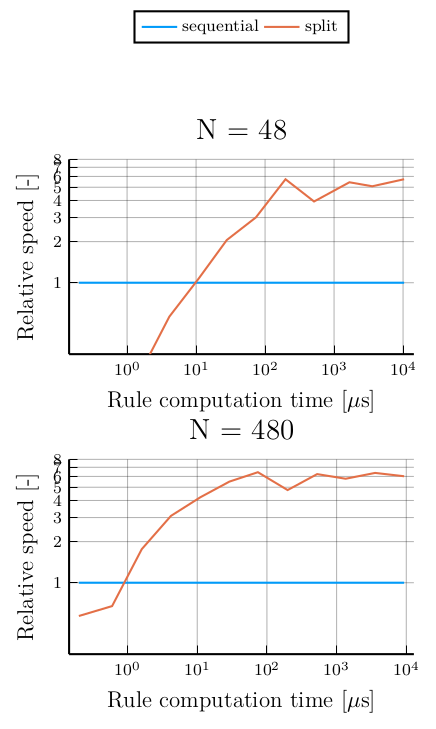

In [25]:
leg = plot(
    framestyle = :none,
    legend = :top,
    #legend_column = length(combinations),
    legend_column = 3
)

for key in [:sequential, :split]
    plot!(leg, [0, 0], [0, 0], label = string(key))
end
l = @layout [a{0.2h}; b; c]

plot(
    leg, p1, p2,
    layout = l,
    size = (300, 500),
)

In [26]:
savefig("plots/coin_toss_split.tikz")

"c:\\Users\\matti\\Documents\\TUe\\Thesis\\ThesisParallelMP\\benchmarks-distributed\\plots\\coin_toss_split.tikz"